# Dimensionality Reduction Evaluation
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate dimensionality reduction techniques for their ability to preserve Euclidean structure of high-dimensional datasets.__  
  
To benchmark these techniques, we are using two single-cell RNAseq datasets:
* From [__Macosko, *et al* (2015)__](https://www.ncbi.nlm.nih.gov/pubmed/26000488), the mouse retina scRNA-seq data generated using DropSeq: [GSM1626793](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1626793)
* From [__Herring, *et al* (2018)__](https://www.ncbi.nlm.nih.gov/pubmed/29153838), the WT mouse colon scRNA-seq data generated using inDrops: [GSM2743164](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2743164)  
  
The first set should be __discrete__, containing highly separable cell populations from the mouse retina, where the latter will be __continuous__, representing a continuum of branching cell states in the gut epithelium.  
  
Both datasets have been __preprocessed and feature-selected__ to allow for direct input to downstream dimensionality reduction algorithms (rather than first performing PCA to limit dimensional input). These methods are shown in [`dev/QC.ipynb`](dev/QC.ipynb).

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *
%matplotlib inline

In [2]:
# ignore numba deprecation warnings given by sc.pp.neighbors()
import numba
import warnings
warnings.simplefilter('ignore', numba.errors.NumbaWarning)
warnings.simplefilter('ignore', numba.errors.NumbaDeprecationWarning)
warnings.simplefilter('ignore', numba.errors.NumbaPerformanceWarning)

In [3]:
# read in Macosko retina data
retina = sc.read('../inputs/GSM1626793_P14Retina_1.processed.h5ad')
# read in Herring colon data
colon = sc.read('../inputs/GSM2743164_rep1_colon_rnaseq.processed.h5ad')

In [4]:
# look at dimensions of counts matrix (cells, genes)
retina

AnnData object with n_obs × n_vars = 1326 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'cluster'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'dca', 'fitsne', 'glmpca', 'pca10', 'pca2', 'scvi', 'scvi_tsne', 'scvis', 'simlr', 'simlr_ydata', 'tsne', 'umap', 'zifa', 'zinbwave'
    layers: 'arcsinh_norm', 'raw_counts'

In [5]:
# look at dimensions of counts matrix (cells, genes)
colon

AnnData object with n_obs × n_vars = 1117 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'cluster'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'dca', 'fitsne', 'glmpca', 'pca10', 'pca2', 'scvi', 'scvi_tsne', 'scvis', 'simlr', 'simlr_ydata', 'tsne', 'umap', 'zifa', 'zinbwave'
    layers: 'arcsinh_norm', 'raw_counts'

In [6]:
# set arcsinh-normalized counts to .X
retina.X = retina.layers['arcsinh_norm'].copy()
colon.X = colon.layers['arcsinh_norm'].copy()

---
### PCA
We'll look at principal component analysis (PCA) first, as a gold-standard. Because PCA performs a __linear__ transformation on the data, 500 PCs should perfectly preserve the overall dataset structure.

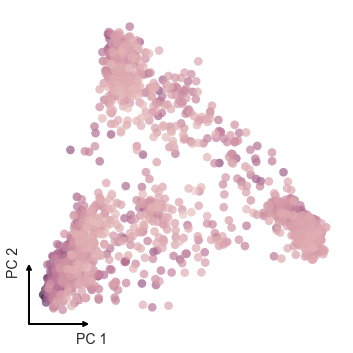

In [7]:
sc.tl.pca(retina, n_comps=500)
retina.obsm['PCA500'] = retina.obsm['X_pca'].copy()
DR_plot(dim_name='PC').plot(retina.obsm['PCA500'], color=retina.obs['log1p_total_counts'])

We can test the Euclidean distance preservation as follows:

In [8]:
# choose value for K-nearest neighbor calculations. We use 30 because that is the standard perplexity chosen for DR techniques here.
k = 30

Calculating unique distances for native space, X
Calculating unique distances for latent space, PCA500
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for native space, X
30-nearest neighbor calculation for latent space, PCA500
Determining nearest neighbor preservation
Done!
R: 1.0
EMD: 0.0
Knn Pres.: 100.0
CPU times: user 7.44 s, sys: 197 ms, total: 7.64 s
Wall time: 3.11 s


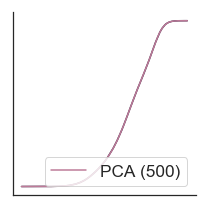

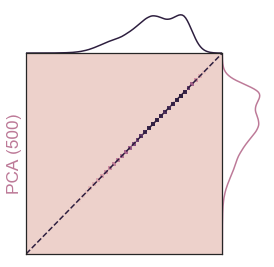

In [9]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=retina, latent='PCA500', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['PCA500_norm_distances'], labels=['','PCA (500)'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['PCA500_norm_distances'], labels=['','PCA (500)']).joint_plot_distance_correlation()

Now we can perform a PCA with a smaller number of components and determine the degree of information loss.  
The extreme example would be comparing only the __first two principal components__ to the original dataset:

In [10]:
# create dictionaries for dumping results into
final_distance_stats = {'Retina':{'R':{}, 'EMD':{}, 'Knn Pres.':{}}, 'Colon':{'R':{}, 'EMD':{}, 'Knn Pres.':{}}}

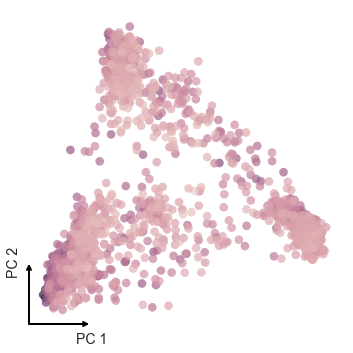

In [11]:
DR_plot(dim_name='PC').plot(retina.obsm['pca2'], color=retina.obs['log1p_total_counts'])

Calculating unique distances for latent space, pca2
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, pca2
Determining nearest neighbor preservation
Done!
R: 0.7718
EMD: 0.2231
Knn Pres.: 96.7996
CPU times: user 2.47 s, sys: 153 ms, total: 2.62 s
Wall time: 1.04 s


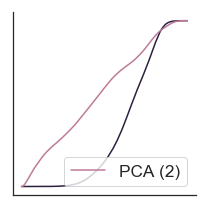

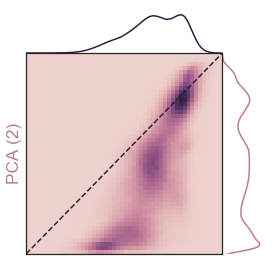

In [13]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=retina, latent='pca2', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['pca2_norm_distances'], labels=['','PCA (2)'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['pca2_norm_distances'], labels=['','PCA (2)']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['PCA (2)'], final_distance_stats['Retina']['EMD']['PCA (2)'], final_distance_stats['Retina']['Knn Pres.']['PCA (2)'] = corr[0], EMD, knn

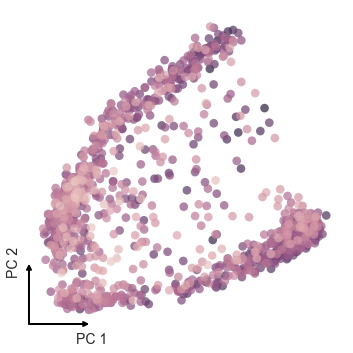

In [14]:
DR_plot(dim_name='PC').plot(colon.obsm['pca2'], color=colon.obs['log1p_total_counts'])

Calculating unique distances for native space, X
Calculating unique distances for latent space, pca2
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for native space, X
30-nearest neighbor calculation for latent space, pca2
Determining nearest neighbor preservation
Done!
R: 0.9381
EMD: 0.0635
Knn Pres.: 97.529
CPU times: user 3.61 s, sys: 142 ms, total: 3.75 s
Wall time: 1.58 s


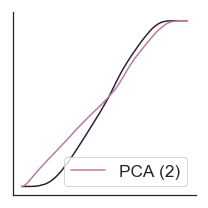

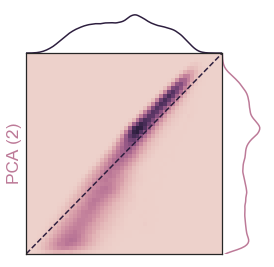

In [15]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=colon, latent='pca2', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['pca2_norm_distances'], labels=['','PCA (2)'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['pca2_norm_distances'], labels=['','PCA (2)']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['PCA (2)'], final_distance_stats['Colon']['EMD']['PCA (2)'], final_distance_stats['Colon']['Knn Pres.']['PCA (2)'] = corr[0], EMD, knn

Now let's do __10 PCs__ to compare to __scVI__ output, which is the only DR method we have that can't return a 2D embedding:

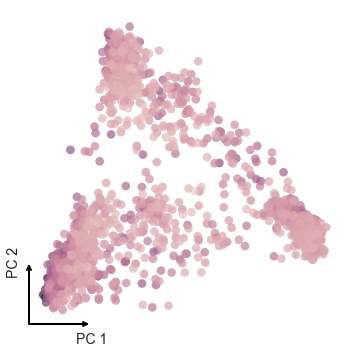

In [16]:
DR_plot(dim_name='PC').plot(retina.obsm['pca10'], color=retina.obs['log1p_total_counts'])

Calculating unique distances for latent space, pca10
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, pca10
Determining nearest neighbor preservation
Done!
R: 0.8557
EMD: 0.1659
Knn Pres.: 97.4033
CPU times: user 3 s, sys: 153 ms, total: 3.16 s
Wall time: 1.14 s


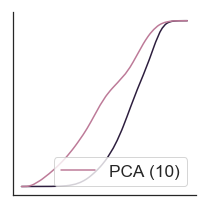

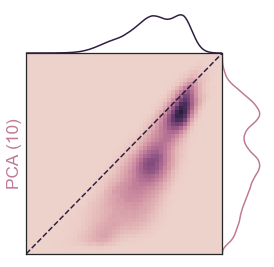

In [17]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=retina, latent='pca10', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['pca10_norm_distances'], labels=['','PCA (10)'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['pca10_norm_distances'], labels=['','PCA (10)'], figsize=(4,4)).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['PCA (10)'], final_distance_stats['Retina']['EMD']['PCA (10)'], final_distance_stats['Retina']['Knn Pres.']['PCA (10)'] = corr[0], EMD, knn

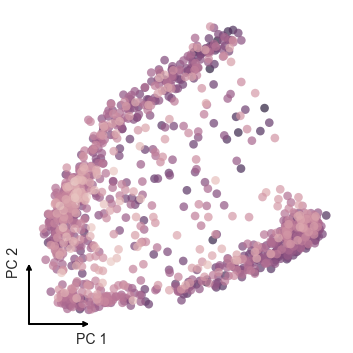

In [18]:
DR_plot(dim_name='PC').plot(colon.obsm['pca10'], color=colon.obs['log1p_total_counts'])

Calculating unique distances for latent space, pca10
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, pca10
Determining nearest neighbor preservation
Done!
R: 0.9688
EMD: 0.0375
Knn Pres.: 98.0704
CPU times: user 2.18 s, sys: 129 ms, total: 2.31 s
Wall time: 787 ms


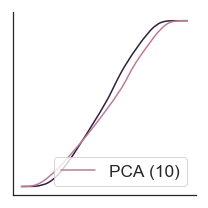

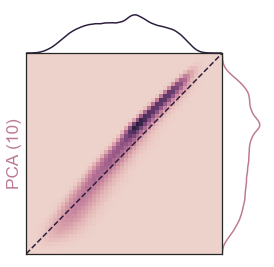

In [19]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=colon, latent='pca10', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['pca10_norm_distances'], labels=['','PCA (10)'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['pca10_norm_distances'], labels=['','PCA (10)']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['PCA (10)'], final_distance_stats['Colon']['EMD']['PCA (10)'], final_distance_stats['Colon']['Knn Pres.']['PCA (10)'] = corr[0], EMD, knn

---
# t-SNE
A workhorse technique for dimensionality reduction and visualization of scRNA-seq datasets, t-SNE performs a stochastic, non-linear transformation to project high-dimensional data into 2D in order to identify clustering and global structure.  
Here, we will plug arcsinh-normalized counts data directly into t-SNE and compare results to the original, feature-selected dataset.

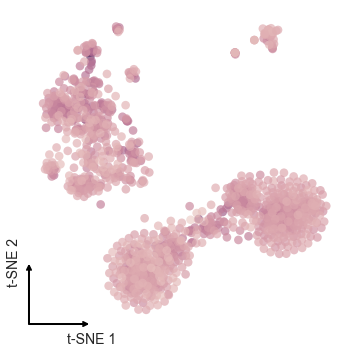

In [20]:
DR_plot(dim_name='t-SNE').plot(retina.obsm['tsne'], color=retina.obs['log1p_total_counts'])

Calculating unique distances for latent space, tsne
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, tsne
Determining nearest neighbor preservation
Done!
R: 0.7739
EMD: 0.2165
Knn Pres.: 96.8218
CPU times: user 2.48 s, sys: 145 ms, total: 2.63 s
Wall time: 1.02 s


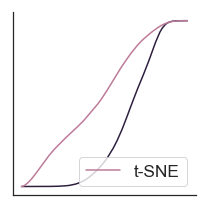

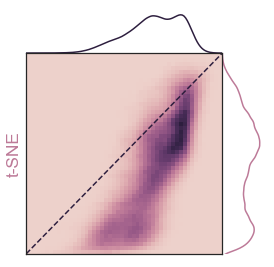

In [21]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=retina, latent='tsne', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['tsne_norm_distances'], labels=['','t-SNE'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['tsne_norm_distances'], labels=['','t-SNE']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['t-SNE'], final_distance_stats['Retina']['EMD']['t-SNE'], final_distance_stats['Retina']['Knn Pres.']['t-SNE'] = corr[0], EMD, knn

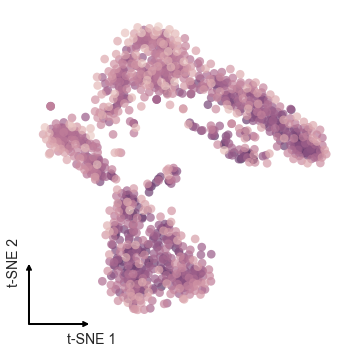

In [22]:
DR_plot(dim_name='t-SNE').plot(colon.obsm['tsne'], color=colon.obs['log1p_total_counts'])

Calculating unique distances for latent space, tsne
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, tsne
Determining nearest neighbor preservation
Done!
R: 0.8816
EMD: 0.0822
Knn Pres.: 97.1733
CPU times: user 1.96 s, sys: 135 ms, total: 2.1 s
Wall time: 798 ms


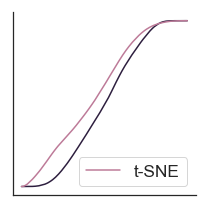

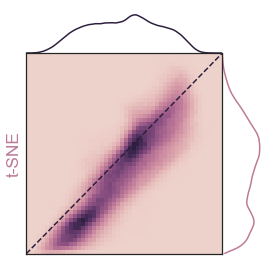

In [23]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=colon, latent='tsne', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['tsne_norm_distances'], labels=['','t-SNE'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['tsne_norm_distances'], labels=['','t-SNE']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['t-SNE'], final_distance_stats['Colon']['EMD']['t-SNE'], final_distance_stats['Colon']['Knn Pres.']['t-SNE'] = corr[0], EMD, knn

---
# FIt-SNE
A workhorse technique for dimensionality reduction and visualization of scRNA-seq datasets, t-SNE performs a stochastic, non-linear transformation to project high-dimensional data into 2D in order to identify clustering and global structure. The FIt-SNE implementation is supposed to be faster and more efficient.  
Here, we will plug arcsinh-normalized counts data directly into t-SNE and compare results to the original, feature-selected dataset.

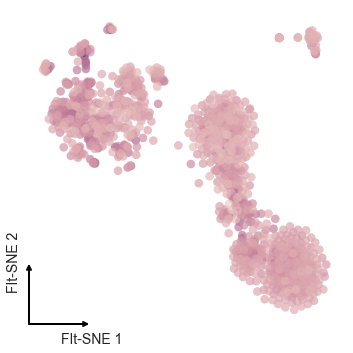

In [24]:
DR_plot(dim_name='FIt-SNE').plot(retina.obsm['fitsne'], color=retina.obs['log1p_total_counts'])

Calculating unique distances for latent space, fitsne
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, fitsne
Determining nearest neighbor preservation
Done!
R: 0.782
EMD: 0.2708
Knn Pres.: 96.8063
CPU times: user 2.44 s, sys: 156 ms, total: 2.6 s
Wall time: 1.03 s


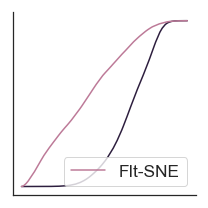

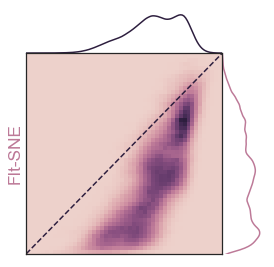

In [25]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=retina, latent='fitsne', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['fitsne_norm_distances'], labels=['','FIt-SNE'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['fitsne_norm_distances'], labels=['','FIt-SNE']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['FIt-SNE'], final_distance_stats['Retina']['EMD']['FIt-SNE'], final_distance_stats['Retina']['Knn Pres.']['FIt-SNE'] = corr[0], EMD, knn

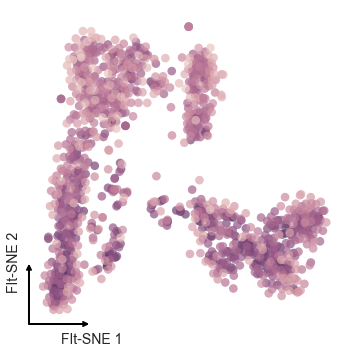

In [26]:
DR_plot(dim_name='FIt-SNE').plot(colon.obsm['fitsne'], color=colon.obs['log1p_total_counts'])

Calculating unique distances for latent space, fitsne
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, fitsne
Determining nearest neighbor preservation
Done!
R: 0.8438
EMD: 0.0691
Knn Pres.: 97.148
CPU times: user 1.94 s, sys: 129 ms, total: 2.07 s
Wall time: 783 ms


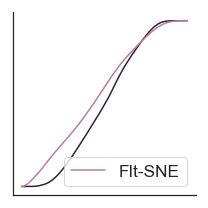

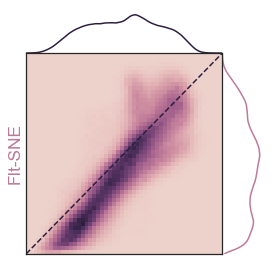

In [27]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=colon, latent='fitsne', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['fitsne_norm_distances'], labels=['','FIt-SNE'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['fitsne_norm_distances'], labels=['','FIt-SNE']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['FIt-SNE'], final_distance_stats['Colon']['EMD']['FIt-SNE'], final_distance_stats['Colon']['Knn Pres.']['FIt-SNE'] = corr[0], EMD, knn

---
# UMAP
Another popular method for low-dimensional projection of scRNA-seq datasets, UMAP creates high-dimensional manifolds that describe the structure of the dataset.  
Here, we will plug arcsinh-normalized counts data directly into UMAP and compare results to the original, feature-selected dataset.

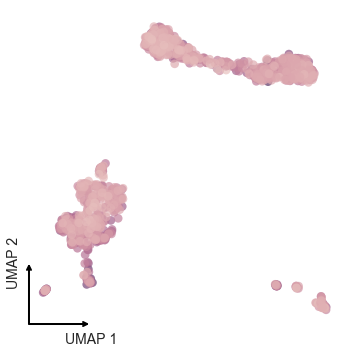

In [28]:
DR_plot(dim_name='UMAP').plot(retina.obsm['umap'], color=retina.obs['log1p_total_counts'])

Calculating unique distances for latent space, umap
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, umap
Determining nearest neighbor preservation
Done!
R: 0.7269
EMD: 0.2247
Knn Pres.: 96.6672
CPU times: user 2.65 s, sys: 155 ms, total: 2.8 s
Wall time: 1.08 s


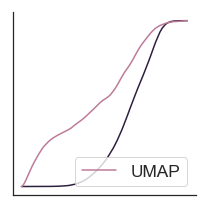

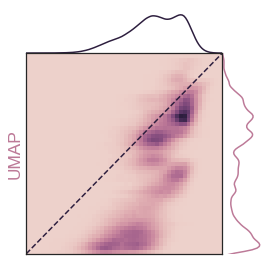

In [29]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=retina, latent='umap', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['umap_norm_distances'], labels=['','UMAP'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['umap_norm_distances'], labels=['','UMAP']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['UMAP'], final_distance_stats['Retina']['EMD']['UMAP'], final_distance_stats['Retina']['Knn Pres.']['UMAP'] = corr[0], EMD, knn

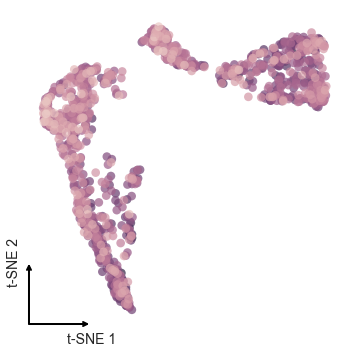

In [30]:
DR_plot(dim_name='t-SNE').plot(colon.obsm['umap'], color=colon.obs['log1p_total_counts'])

Calculating unique distances for latent space, umap
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, umap
Determining nearest neighbor preservation
Done!
R: 0.8002
EMD: 0.0936
Knn Pres.: 97.1171
CPU times: user 1.88 s, sys: 135 ms, total: 2.02 s
Wall time: 794 ms


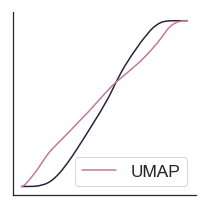

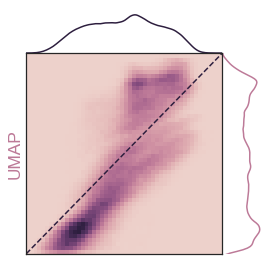

In [31]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=colon, latent='umap', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['umap_norm_distances'], labels=['','UMAP'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['umap_norm_distances'], labels=['','UMAP']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['UMAP'], final_distance_stats['Colon']['EMD']['UMAP'], final_distance_stats['Colon']['Knn Pres.']['UMAP'] = corr[0], EMD, knn

---
# ZIFA
This method uses the zero-inflated negative binomial distribution to reduce RNA counts data to lower dimensions.  
Here, we will plug arcsinh-normalized counts data directly into ZIFA and compare results to the original, feature-selected dataset.

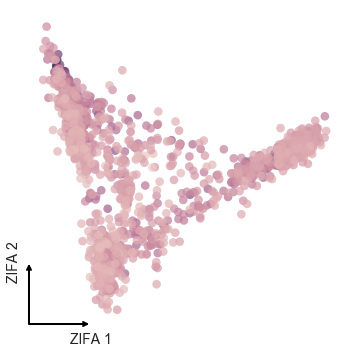

In [32]:
DR_plot(dim_name='ZIFA').plot(retina.obsm['zifa'], color=retina.obs['log1p_total_counts'])

Calculating unique distances for latent space, zifa
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, zifa
Determining nearest neighbor preservation
Done!
R: 0.6864
EMD: 0.2991
Knn Pres.: 96.5919
CPU times: user 2.39 s, sys: 143 ms, total: 2.53 s
Wall time: 1.03 s


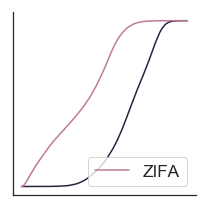

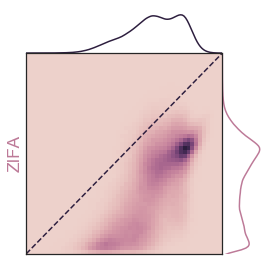

In [33]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=retina, latent='zifa', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['zifa_norm_distances'], labels=['','ZIFA'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['zifa_norm_distances'], labels=['','ZIFA']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['ZIFA'], final_distance_stats['Retina']['EMD']['ZIFA'], final_distance_stats['Retina']['Knn Pres.']['ZIFA'] = corr[0], EMD, knn

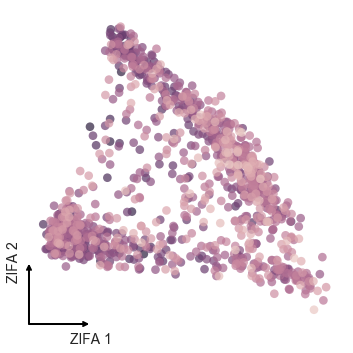

In [34]:
DR_plot(dim_name='ZIFA').plot(colon.obsm['zifa'], color=colon.obs['log1p_total_counts'])

Calculating unique distances for latent space, zifa
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, zifa
Determining nearest neighbor preservation
Done!
R: 0.8659
EMD: 0.1364
Knn Pres.: 96.9169
CPU times: user 2 s, sys: 127 ms, total: 2.13 s
Wall time: 782 ms


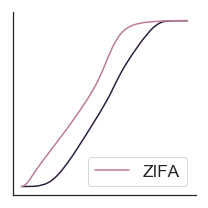

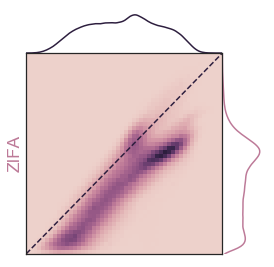

In [35]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=colon, latent='zifa', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['zifa_norm_distances'], labels=['','ZIFA'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['zifa_norm_distances'], labels=['','ZIFA']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['ZIFA'], final_distance_stats['Colon']['EMD']['ZIFA'], final_distance_stats['Colon']['Knn Pres.']['ZIFA'] = corr[0], EMD, knn

---
# DCA
This method uses a deep count autoencoder to reduce RNA counts data to lower dimensions.  
Here, we will plug counts data directly into DCA and compare results to the original, feature-selected dataset.

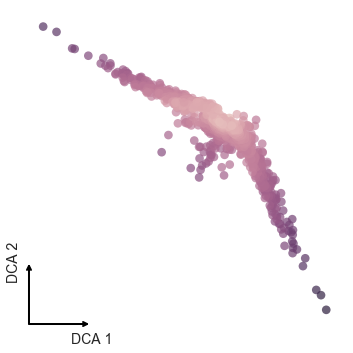

In [36]:
DR_plot(dim_name='DCA').plot(retina.obsm['dca'], color=retina.obs['log1p_total_counts'])

Calculating unique distances for latent space, dca
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, dca
Determining nearest neighbor preservation
Done!
R: 0.2105
EMD: 0.5303
Knn Pres.: 96.7021
CPU times: user 2.49 s, sys: 141 ms, total: 2.63 s
Wall time: 1.04 s


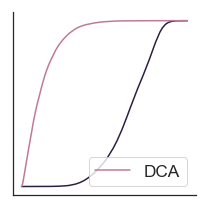

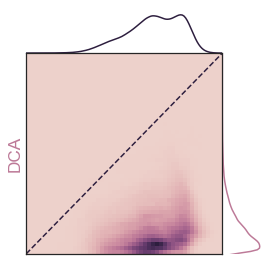

In [37]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=retina, latent='dca', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['dca_norm_distances'], labels=['','DCA'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['dca_norm_distances'], labels=['','DCA']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['DCA'], final_distance_stats['Retina']['EMD']['DCA'], final_distance_stats['Retina']['Knn Pres.']['DCA'] = corr[0], EMD, knn

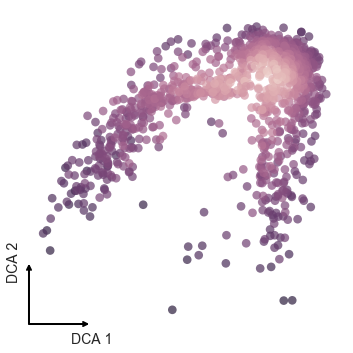

In [38]:
DR_plot(dim_name='DCA').plot(colon.obsm['dca'], color=colon.obs['log1p_total_counts'])

Calculating unique distances for latent space, dca
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, dca
Determining nearest neighbor preservation
Done!
R: 0.5213
EMD: 0.1954
Knn Pres.: 96.2199
CPU times: user 2.02 s, sys: 137 ms, total: 2.16 s
Wall time: 776 ms


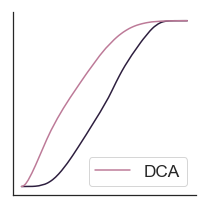

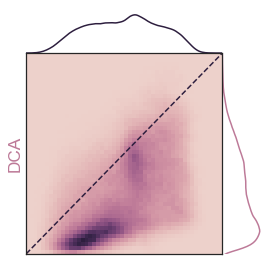

In [39]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=colon, latent='dca', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['dca_norm_distances'], labels=['','DCA'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['dca_norm_distances'], labels=['','DCA']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['DCA'], final_distance_stats['Colon']['EMD']['DCA'], final_distance_stats['Colon']['Knn Pres.']['DCA'] = corr[0], EMD, knn

---
# sc-VI

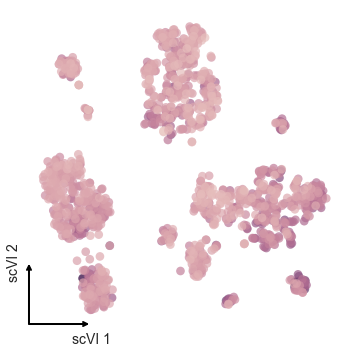

In [40]:
DR_plot(dim_name='scVI').plot(retina.obsm['scvi_tsne'], color=retina.obs['log1p_total_counts'])

Calculating unique distances for latent space, scvi
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, scvi
Determining nearest neighbor preservation
Done!
R: 0.6553
EMD: 0.2052
Knn Pres.: 96.7922
CPU times: user 5.17 s, sys: 145 ms, total: 5.31 s
Wall time: 1.33 s


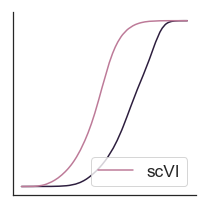

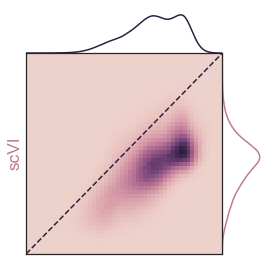

In [41]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=retina, latent='scvi', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['scvi_norm_distances'], labels=['','scVI'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['scvi_norm_distances'], labels=['','scVI']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['scVI'], final_distance_stats['Retina']['EMD']['scVI'], final_distance_stats['Retina']['Knn Pres.']['scVI'] = corr[0], EMD, knn

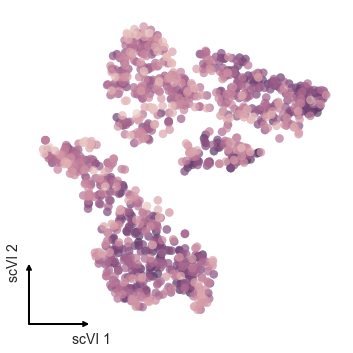

In [42]:
DR_plot(dim_name='scVI').plot(colon.obsm['scvi_tsne'], color=colon.obs['log1p_total_counts'])

Calculating unique distances for latent space, scvi
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, scvi
Determining nearest neighbor preservation
Done!
R: 0.857
EMD: 0.0725
Knn Pres.: 96.9871
CPU times: user 3.11 s, sys: 127 ms, total: 3.23 s
Wall time: 890 ms


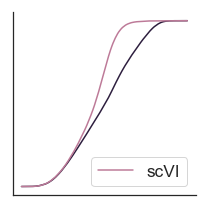

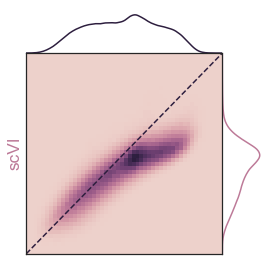

In [43]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=colon, latent='scvi', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['scvi_norm_distances'], labels=['','scVI'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['scvi_norm_distances'], labels=['','scVI']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['scVI'], final_distance_stats['Colon']['EMD']['scVI'], final_distance_stats['Colon']['Knn Pres.']['scVI'] = corr[0], EMD, knn

---
# scvis

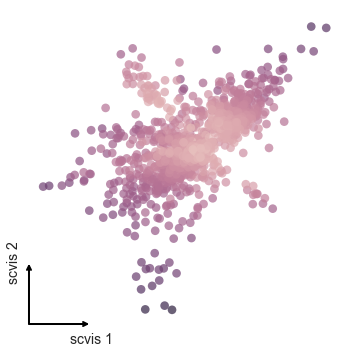

In [44]:
DR_plot(dim_name='scvis').plot(retina.obsm['scvis'], color=retina.obs['log1p_total_counts'])

Calculating unique distances for latent space, scvis
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, scvis
Determining nearest neighbor preservation
Done!
R: 0.304
EMD: 0.4846
Knn Pres.: 96.7131
CPU times: user 2.72 s, sys: 138 ms, total: 2.86 s
Wall time: 1.11 s


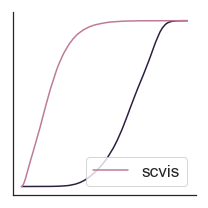

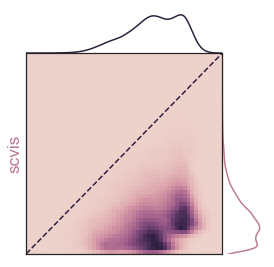

In [45]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=retina, latent='scvis', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['scvis_norm_distances'], labels=['','scvis'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['scvis_norm_distances'], labels=['','scvis']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['scvis'], final_distance_stats['Retina']['EMD']['scvis'], final_distance_stats['Retina']['Knn Pres.']['scvis'] = corr[0], EMD, knn

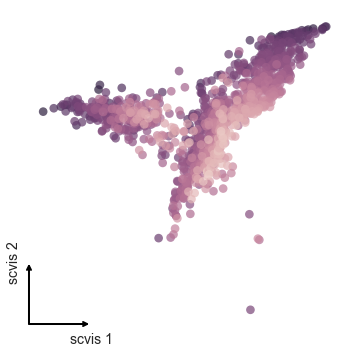

In [46]:
DR_plot(dim_name='scvis').plot(colon.obsm['scvis'], color=colon.obs['log1p_total_counts'])

Calculating unique distances for latent space, scvis
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, scvis
Determining nearest neighbor preservation
Done!
R: 0.527
EMD: 0.2322
Knn Pres.: 95.8854
CPU times: user 2.03 s, sys: 149 ms, total: 2.18 s
Wall time: 782 ms


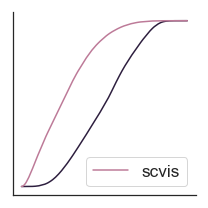

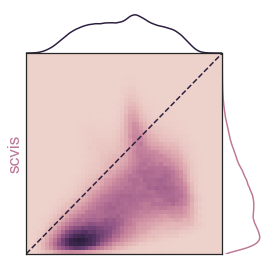

In [47]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=colon, latent='scvis', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['scvis_norm_distances'], labels=['','scvis'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['scvis_norm_distances'], labels=['','scvis']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['scvis'], final_distance_stats['Colon']['EMD']['scvis'], final_distance_stats['Colon']['Knn Pres.']['scvis'] = corr[0], EMD, knn

---
# SIMLR
This method builds cell-cell similarity matrices to predict cluster number and assign cells to clusters based on similarity.
First, read in the `F` construct that consists of a c-dimensional output of length `n_cells`, where c is the number of expected clusters passed to SIMLR.  
Here, c was the number of clusters determined by Seurat Louvain algorithm.

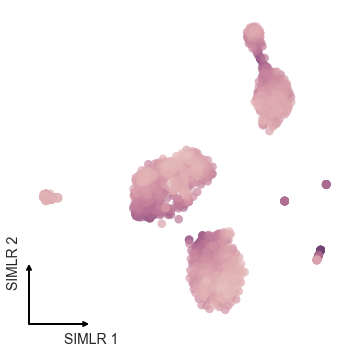

In [48]:
DR_plot(dim_name='SIMLR').plot(retina.obsm['simlr_ydata'], color=retina.obs['log1p_total_counts'])

Calculating unique distances for latent space, simlr
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, simlr
Determining nearest neighbor preservation
Done!
R: 0.526
EMD: 0.3275
Knn Pres.: 97.2329
CPU times: user 2.49 s, sys: 144 ms, total: 2.64 s
Wall time: 1.03 s


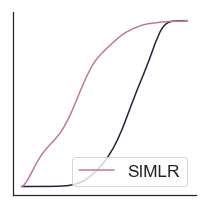

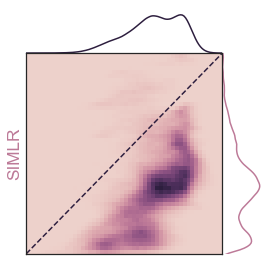

In [49]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=retina, latent='simlr', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['simlr_norm_distances'], labels=['','SIMLR'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['simlr_norm_distances'], labels=['','SIMLR']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['SIMLR'], final_distance_stats['Retina']['EMD']['SIMLR'], final_distance_stats['Retina']['Knn Pres.']['SIMLR'] = corr[0], EMD, knn

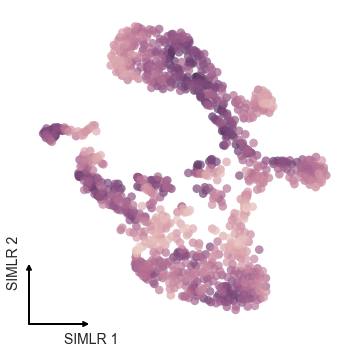

In [50]:
DR_plot(dim_name='SIMLR').plot(colon.obsm['simlr_ydata'], color=colon.obs['log1p_total_counts'])

Calculating unique distances for latent space, simlr
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, simlr
Determining nearest neighbor preservation
Done!
R: 0.7662
EMD: 0.0849
Knn Pres.: 96.8255
CPU times: user 2.05 s, sys: 145 ms, total: 2.2 s
Wall time: 839 ms


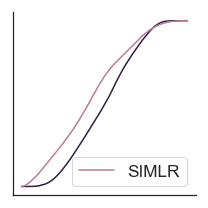

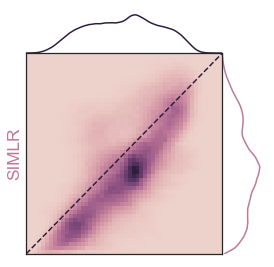

In [51]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=colon, latent='simlr', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['simlr_norm_distances'], labels=['','SIMLR'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['simlr_norm_distances'], labels=['','SIMLR']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['SIMLR'], final_distance_stats['Colon']['EMD']['SIMLR'], final_distance_stats['Colon']['Knn Pres.']['SIMLR'] = corr[0], EMD, knn

---
### ZINB-WAVE

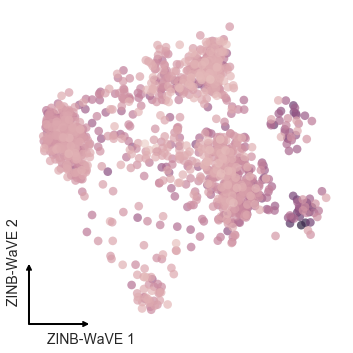

In [52]:
DR_plot(dim_name='ZINB-WaVE').plot(retina.obsm['zinbwave'], color=retina.obs['log1p_total_counts'])

Calculating unique distances for latent space, zinbwave
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, zinbwave
Determining nearest neighbor preservation
Done!
R: 0.7916
EMD: 0.273
Knn Pres.: 96.6629
CPU times: user 2.56 s, sys: 135 ms, total: 2.7 s
Wall time: 1.01 s


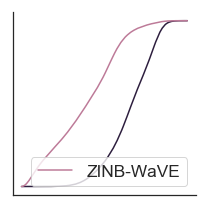

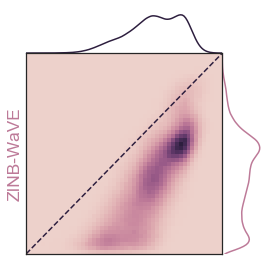

In [53]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=retina, latent='zinbwave', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['zinbwave_norm_distances'], labels=['','ZINB-WaVE'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['zinbwave_norm_distances'], labels=['','ZINB-WaVE']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['ZINB-WaVE'], final_distance_stats['Retina']['EMD']['ZINB-WaVE'], final_distance_stats['Retina']['Knn Pres.']['ZINB-WaVE'] = corr[0], EMD, knn

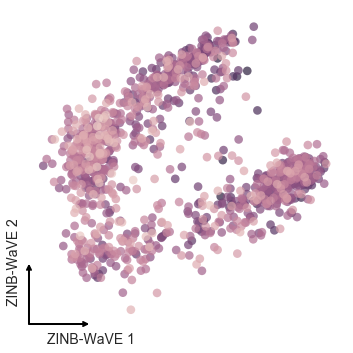

In [54]:
DR_plot(dim_name='ZINB-WaVE').plot(colon.obsm['zinbwave'], color=colon.obs['log1p_total_counts'])

Calculating unique distances for latent space, zinbwave
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, zinbwave
Determining nearest neighbor preservation
Done!
R: 0.9218
EMD: 0.0877
Knn Pres.: 96.7756
CPU times: user 2.03 s, sys: 131 ms, total: 2.16 s
Wall time: 787 ms


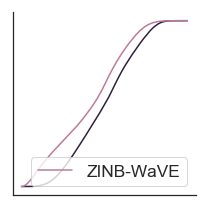

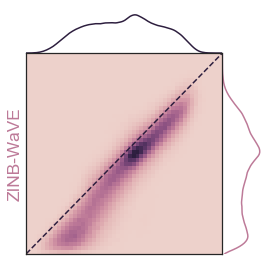

In [55]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=colon, latent='zinbwave', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['zinbwave_norm_distances'], labels=['','ZINB-WaVE'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['zinbwave_norm_distances'], labels=['','ZINB-WaVE']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['ZINB-WaVE'], final_distance_stats['Colon']['EMD']['ZINB-WaVE'], final_distance_stats['Colon']['Knn Pres.']['ZINB-WaVE'] = corr[0], EMD, knn

---
### GLM-PCA

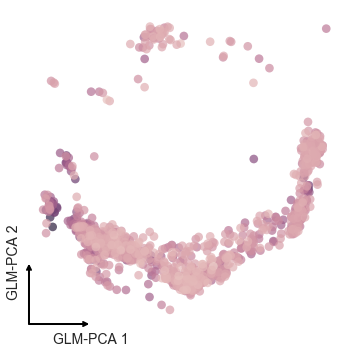

In [56]:
DR_plot(dim_name='GLM-PCA').plot(retina.obsm['glmpca'], color=retina.obs['log1p_total_counts'])

Calculating unique distances for latent space, glmpca
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, glmpca
Determining nearest neighbor preservation
Done!
R: 0.7918
EMD: 0.2926
Knn Pres.: 96.6734
CPU times: user 2.39 s, sys: 148 ms, total: 2.54 s
Wall time: 1.02 s


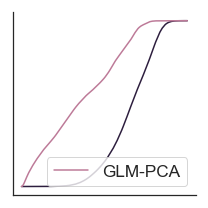

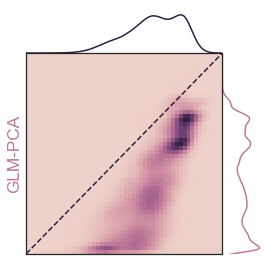

In [57]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=retina, latent='glmpca', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['glmpca_norm_distances'], labels=['','GLM-PCA'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=retina.uns['X_norm_distances'], post_norm=retina.uns['glmpca_norm_distances'], labels=['','GLM-PCA']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['GLM-PCA'], final_distance_stats['Retina']['EMD']['GLM-PCA'], final_distance_stats['Retina']['Knn Pres.']['GLM-PCA'] = corr[0], EMD, knn

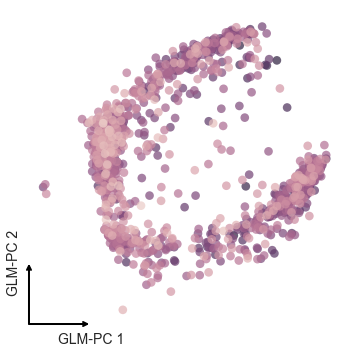

In [58]:
DR_plot(dim_name='GLM-PC').plot(colon.obsm['glmpca'], color=colon.obs['log1p_total_counts'])

Calculating unique distances for latent space, glmpca
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, glmpca
Determining nearest neighbor preservation
Done!
R: 0.9317
EMD: 0.1058
Knn Pres.: 96.9085
CPU times: user 2.03 s, sys: 132 ms, total: 2.17 s
Wall time: 837 ms


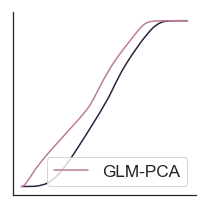

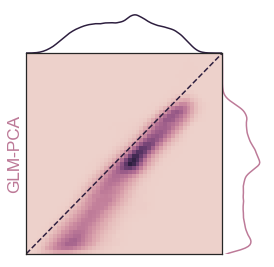

In [59]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=colon, latent='glmpca', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['glmpca_norm_distances'], labels=['','GLM-PCA'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=colon.uns['X_norm_distances'], post_norm=colon.uns['glmpca_norm_distances'], labels=['','GLM-PCA']).joint_plot_distance_correlation()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['GLM-PCA'], final_distance_stats['Colon']['EMD']['GLM-PCA'], final_distance_stats['Colon']['Knn Pres.']['GLM-PCA'] = corr[0], EMD, knn

---
## Summary Metrics

In [60]:
retina_sum = pd.DataFrame(final_distance_stats['Retina'])
retina_sum = retina_sum.sort_values(by='R')
retina_sum = retina_sum.reindex(['EMD','R','Knn Pres.'], axis=1)
retina_sum.to_csv('outputs/retina_global_metrics.csv')

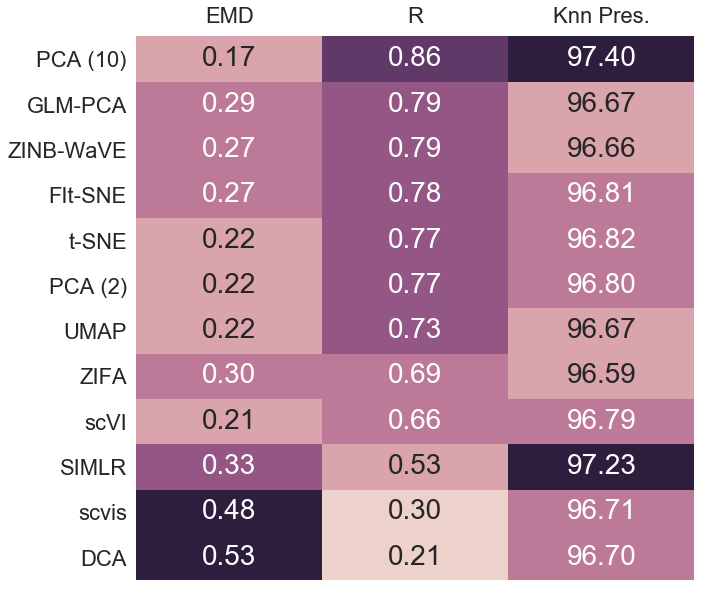

In [61]:
retina_norm=(retina_sum-retina_sum.mean())/retina_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(retina_norm, annot=retina_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.tick_params(top=False)
plt.show()

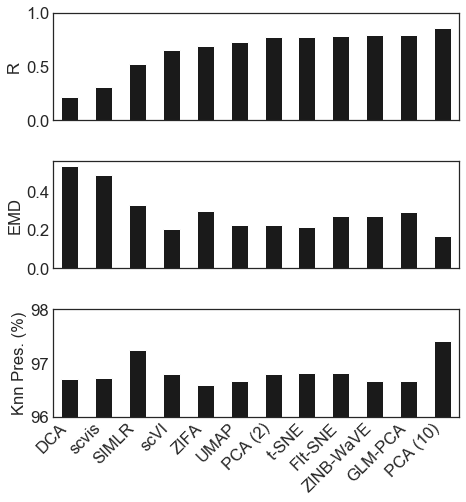

In [80]:
with plt.style.context('seaborn-white'):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7,7.5), sharex='col')
    retina_sum[['R']].plot(ax=axes[0],kind='bar', legend=False, color='k')
    retina_sum[['EMD']].plot(ax=axes[1],kind='bar', legend=False, color='k')
    retina_sum[['Knn Pres.']].plot(ax=axes[2],kind='bar', legend=False, color='k')
    axes[0].set_ylabel('R', fontsize='x-small')
    axes[0].set_yticks([0.0,0.5,1.0])
    axes[1].set_ylabel('EMD', fontsize='x-small')
    axes[2].set_ylim([96, 98])
    axes[2].set_ylabel('Knn Pres. (%)', fontsize='x-small')
    axes[0].tick_params(labelsize='x-small')
    axes[1].tick_params(labelsize='x-small')
    axes[2].tick_params(labelsize='x-small')
    axes[2].set_xticklabels(retina_sum.index, rotation=45, ha='right')
    plt.tight_layout()

In [66]:
colon_sum = pd.DataFrame(final_distance_stats['Colon'])
colon_sum = colon_sum.sort_values(by='R')
colon_sum = colon_sum.reindex(['EMD','R','Knn Pres.'], axis=1)
colon_sum.to_csv('outputs/colon_global_metrics.csv')

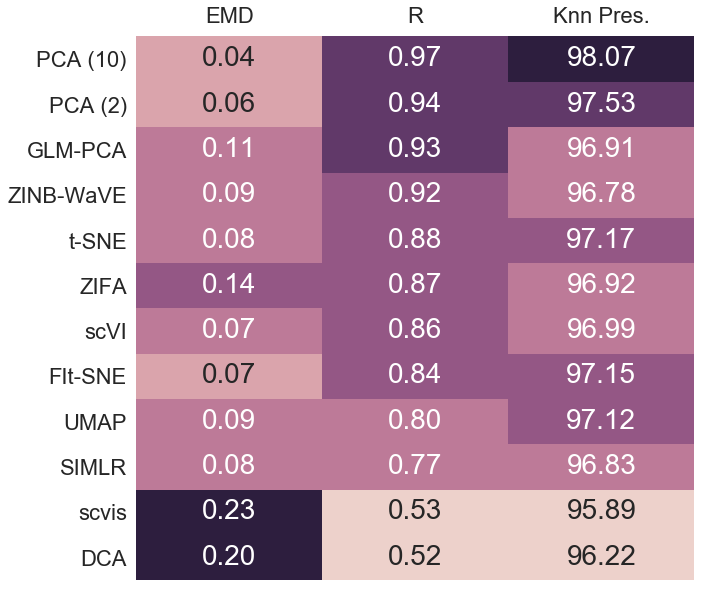

In [67]:
colon_norm=(colon_sum-colon_sum.mean())/colon_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(colon_norm, annot=colon_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.tick_params(top=False)
plt.show()

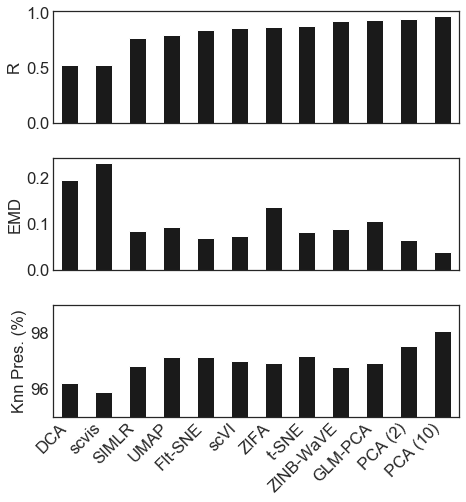

In [81]:
with plt.style.context('seaborn-white'):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7,7.5), sharex='col')
    colon_sum[['R']].plot(ax=axes[0],kind='bar', legend=False, color='k')
    colon_sum[['EMD']].plot(ax=axes[1],kind='bar', legend=False, color='k')
    colon_sum[['Knn Pres.']].plot(ax=axes[2],kind='bar', legend=False, color='k')
    axes[0].set_ylabel('R', fontsize='x-small')
    #axes[0].set_yticks([0.0,0.5,1.0])
    axes[1].set_ylabel('EMD', fontsize='x-small')
    axes[2].set_ylim([95, 99])
    axes[2].set_ylabel('Knn Pres. (%)', fontsize='x-small')
    axes[0].tick_params(labelsize='x-small')
    axes[1].tick_params(labelsize='x-small')
    axes[2].tick_params(labelsize='x-small')
    axes[2].set_xticklabels(colon_sum.index, rotation=45, ha='right')
    plt.tight_layout()